Code adapted from https://github.com/williamfoote/iMessageWordleStats, thankyou!

Last run: 8/30/24

In [25]:
import sqlite3
import pandas as pd
from datetime import datetime
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [26]:
# message data located in chat.db
# to connect to database of mac with VS Code: settings > privacy & security > full disk access > toggle VS Code to 'allow'
conn = sqlite3.connect('/Users/USERNAME/Library/Messages/chat.db')
cur = conn.cursor()

# query database for table names
cur.execute(" select name from sqlite_master where type = 'table' ")

for name in cur.fetchall():
    print(name)

('_SqliteDatabaseProperties',)
('deleted_messages',)
('sqlite_sequence',)
('chat_handle_join',)
('sync_deleted_messages',)
('message_processing_task',)
('handle',)
('sync_deleted_chats',)
('message_attachment_join',)
('sync_deleted_attachments',)
('kvtable',)
('chat_message_join',)
('message',)
('chat',)
('attachment',)
('chat_recoverable_message_join',)
('unsynced_removed_recoverable_messages',)
('recoverable_message_part',)
('sqlite_stat1',)


In [27]:
# create pandas dataframe with relevant tables

# converts a timestamp stored in the date column to a UTC datetime format from message table
messages = pd.read_sql_query('''select *, datetime(date/1000000000 + strftime("%s", "2001-01-01"),"unixepoch","localtime")  as date_utc from message''', conn) 

# selects all columns and rows from the handle table
handles = pd.read_sql_query("select * from handle", conn)

# selects all columns and rows from the chat_message_join table
chat_message_joins = pd.read_sql_query("select * from chat_message_join", conn)

In [28]:
# cleaning data for date-time analysis
messages['message_date'] = messages['date']
messages['timestamp'] = messages['date_utc'].apply(lambda x: pd.Timestamp(x))
messages['date'] = messages['timestamp'].apply(lambda x: x.date())
messages['month'] = messages['timestamp'].apply(lambda x: int(x.month))
messages['year'] = messages['timestamp'].apply(lambda x: int(x.year))

# rename the ROWID into message_id for clarity
messages.rename(columns={'ROWID' : 'message_id'}, inplace = True)

# rename the handle and apple_id/phone_number as well
handles.rename(columns={'id' : 'phone_number', 'ROWID': 'handle_id'}, inplace = True)

In [29]:
# merge the messages with the handles
merge_level_1 = pd.merge(messages[['text', 'handle_id', 'date','message_date' ,'timestamp', 'month','year','is_sent', 'message_id']],  handles[['handle_id', 'phone_number']], on ='handle_id', how='left')

# and then that table with the chats
df_messages = pd.merge(merge_level_1, chat_message_joins[['chat_id', 'message_id']], on = 'message_id', how='left')

print(len(df_messages))

78512


In [30]:
# filtering dataframe by key word "Wordle" to get all related chats
wordle_scores = df_messages.loc[df_messages['text'].str.contains("Wordle", na=False)]

# removes all reactions to wordles (ie. ___ Laughed at "Wordle ...")
filtered_wordle_scores = wordle_scores.loc[~wordle_scores['text'].str.contains('“Wordle ', na=False)]

print(len(filtered_wordle_scores))

2616


In [31]:
# replaces phone numbers with names
filtered_wordle_scores.loc[pd.isnull(filtered_wordle_scores['phone_number']), 'phone_number'] = 'Margo'
filtered_wordle_scores.loc[filtered_wordle_scores['phone_number'] == '+12345678910', 'phone_number'] = 'Chief'
filtered_wordle_scores.loc[filtered_wordle_scores['phone_number'] == '+12345678910', 'phone_number'] = 'Grammy'
filtered_wordle_scores.loc[filtered_wordle_scores['phone_number'] == 'janedoe@gmail.com', 'phone_number'] = 'Grammy'
filtered_wordle_scores.loc[filtered_wordle_scores['phone_number'] == '+12345678910', 'phone_number'] = 'Dad'
filtered_wordle_scores.loc[filtered_wordle_scores['phone_number'] == '+12345678910', 'phone_number'] = 'Mom'
filtered_wordle_scores.loc[filtered_wordle_scores['phone_number'] == '+12345678910', 'phone_number'] = 'Uncle'
filtered_wordle_scores.loc[filtered_wordle_scores['phone_number'] == '+12345678910', 'phone_number'] = 'Nol'

In [32]:
# since I've played Wordle with people outside of my family group chat, this removes chats that I don't want in the analysis
valid_phone_numbers = [
    'Chief',
    'Grammy', 
    'Dad',
    'Mom', 
    'Uncle', 
    'Nol',
    'Margo'
]

fully_filtered = filtered_wordle_scores[filtered_wordle_scores['phone_number'].isin(valid_phone_numbers)]

fully_filtered.to_csv("imessages.csv")

In [33]:
cleaned = fully_filtered.copy(deep=True)

In [34]:
score = []

for line in cleaned.text:
    match = re.search(r'([1-6X])/6', line)
    if match:
        raw_score = match.group(1)
        format_score_misses = int(raw_score.replace('X', '7'))
        score.append(format_score_misses)

score_length = len(score)

print(score_length)

2440


In [35]:
wordle_num = []

for line in cleaned.text:
    match = re.findall(r"\d{1,3}(?:,\d{3})*(?= \w)", line)
    if match:
        this_num = int(match[0].replace(',', ''))
        wordle_num.append(this_num)

print(wordle_num)

[801, 801, 801, 801, 802, 802, 802, 802, 802, 802, 803, 803, 803, 803, 803, 803, 804, 804, 804, 804, 804, 804, 805, 804, 805, 805, 805, 805, 805, 806, 806, 806, 806, 806, 806, 807, 807, 807, 807, 807, 807, 807, 807, 808, 808, 808, 808, 808, 808, 809, 809, 809, 809, 809, 809, 810, 810, 810, 810, 810, 810, 810, 811, 811, 811, 811, 811, 811, 811, 812, 812, 812, 812, 812, 812, 813, 813, 813, 813, 813, 813, 814, 814, 814, 814, 814, 814, 814, 815, 815, 815, 815, 815, 815, 815, 816, 816, 816, 816, 816, 816, 817, 817, 817, 817, 817, 817, 817, 818, 818, 818, 818, 818, 818, 819, 819, 819, 819, 819, 819, 820, 820, 820, 820, 820, 820, 820, 821, 821, 821, 821, 821, 821, 821, 822, 822, 822, 822, 822, 822, 823, 823, 823, 823, 823, 823, 823, 824, 824, 824, 824, 824, 824, 824, 825, 825, 825, 825, 825, 825, 825, 826, 826, 826, 826, 826, 826, 827, 827, 827, 827, 827, 827, 828, 828, 828, 828, 828, 828, 828, 829, 829, 829, 829, 829, 829, 830, 830, 830, 830, 830, 830, 831, 831, 831, 831, 831, 831, 831, 832,

In [36]:
score_df = pd.DataFrame(score)
wordle_num_df = pd.DataFrame(wordle_num)
cleaned_df = pd.concat([wordle_num_df, cleaned.reset_index(drop=True), score_df], axis =1, ignore_index = True)
cleaned_df.columns = ['wordle_num', 'text', 'handle_id', 'date', 'message_date', 'timestamp', 'month',
                      'year', 'is_sent', 'message_id', 'phone_number', 'chat_id', 'score']

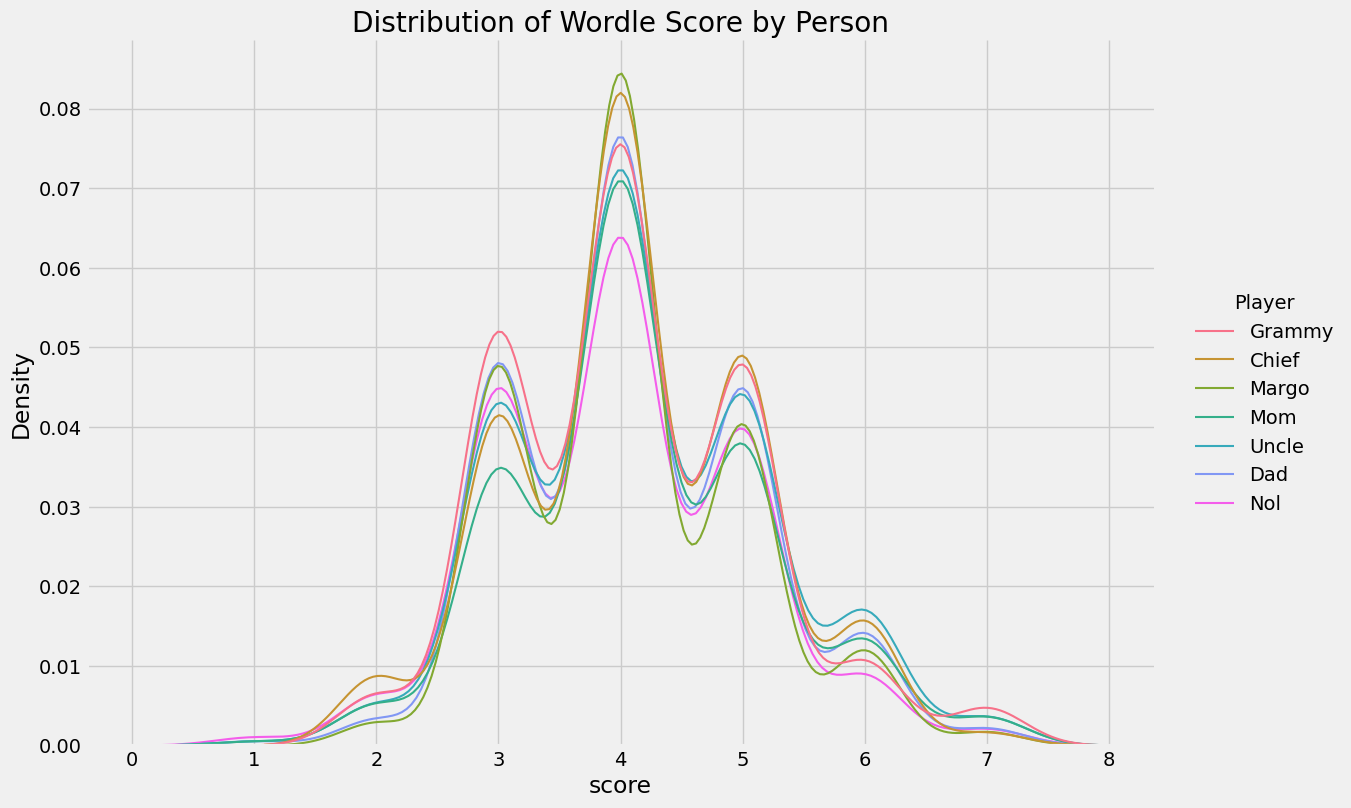

In [37]:
g = sns.displot(
    cleaned_df,
    x="score",
    hue="phone_number",
    kind="kde",
    linewidth=1.5,
    height=8,
    aspect=1.5 
).set(title="Distribution of Wordle Score by Person")

g._legend.set_title("Player") 

plt.show()

/Users/margofmiller/Desktop/Projects/WordleStats-2/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:478: UserWarning: `gridspec_kws` ignored when using `col_wrap`
  warnings.warn("`gridspec_kws` ignored when using `col_wrap`")


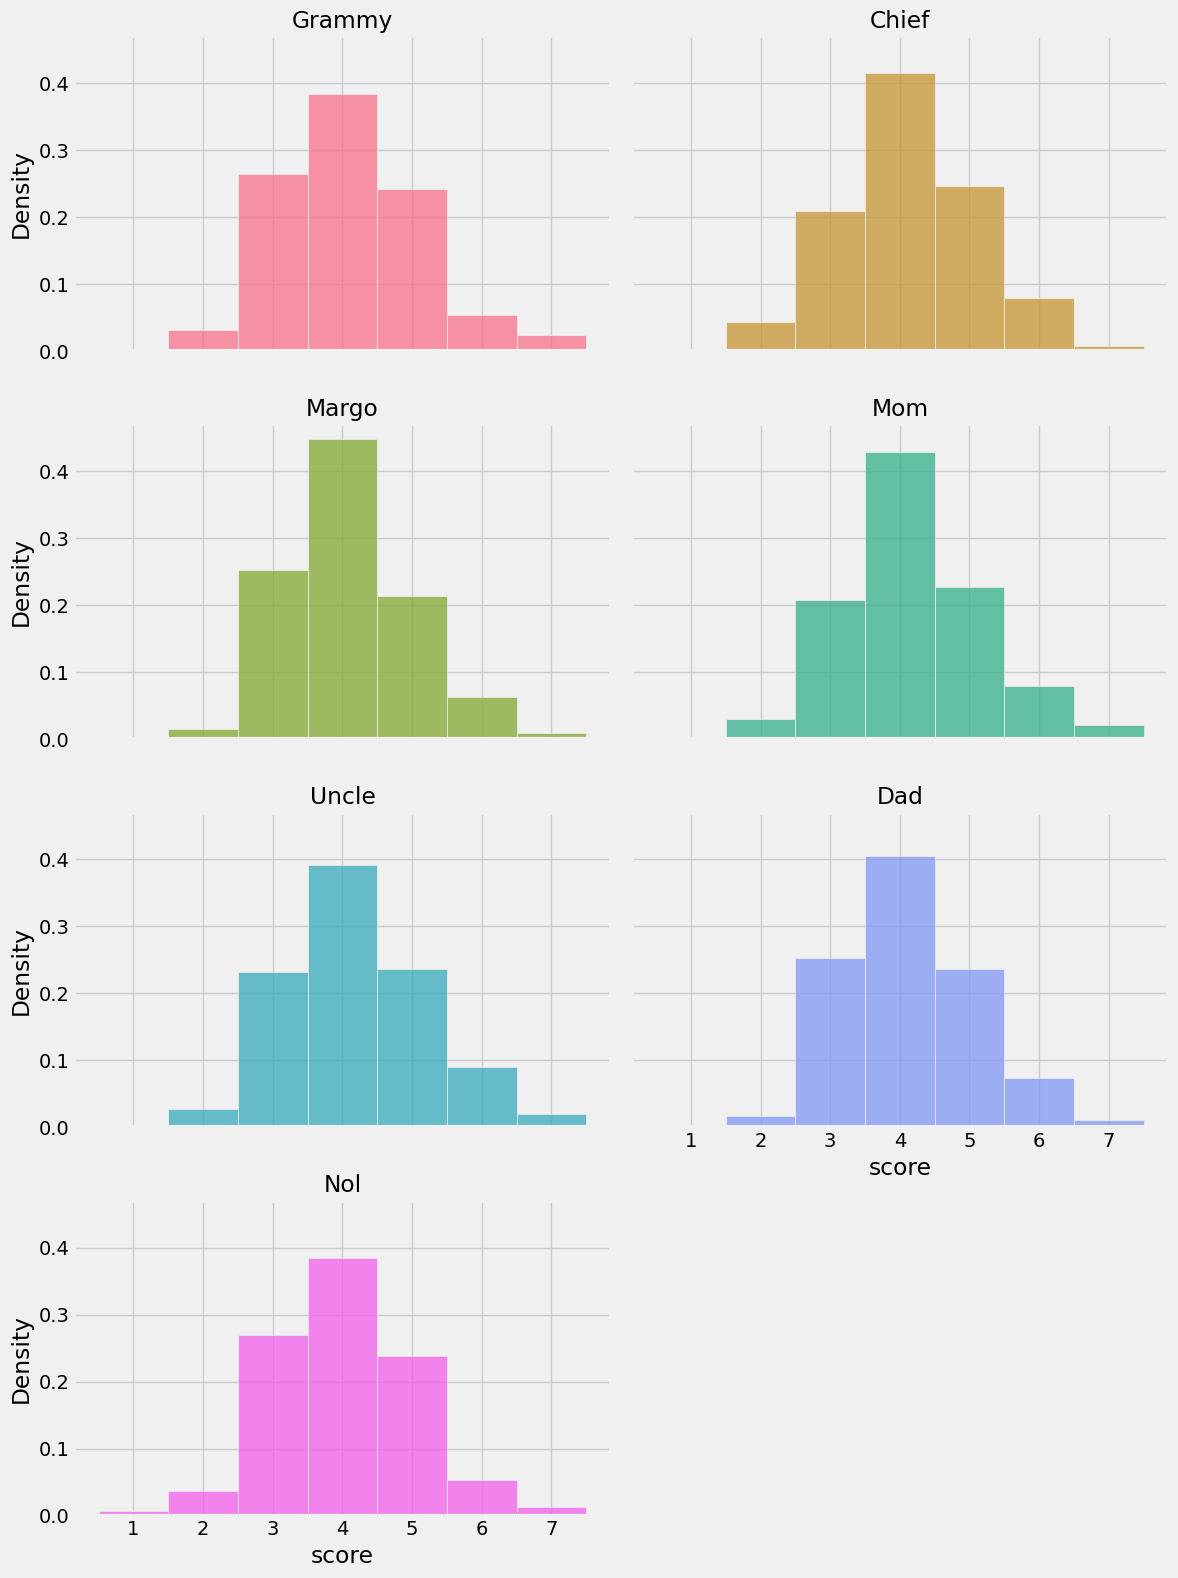

In [38]:
h = sns.FacetGrid(
    cleaned_df,
    col='phone_number',
    hue='phone_number',
    col_wrap=2,
    height=4,
    aspect=1.5,
    margin_titles=True,  # keeps titles centered over columns
    despine=False,  # removes the top and right spines
    gridspec_kws={"wspace": 0.2, "hspace": 0.4}
)

h.map(sns.histplot, "score", discrete=True, stat="density")

# set x-ticks and labels
h.set(xticks=[1, 2, 3, 4, 5, 6, 7])
h.set_xticklabels([1, 2, 3, 4, 5, 6, 7])

# set titles to just show the phone number
h.set_titles("{col_name}")

plt.show()


In [39]:
cleaned_df.groupby("phone_number")['score'].describe().sort_values('mean', ascending=True).reset_index()

,phone_number,count,mean,std,min,25%,50%,75%,max
0,Nol,323.0,4.018576,1.018293,1.0,3.0,4.0,5.0,7.0
1,Margo,333.0,4.084084,0.924313,2.0,3.0,4.0,5.0,7.0
2,Grammy,375.0,4.093333,1.028645,2.0,3.0,4.0,5.0,7.0
3,Dad,351.0,4.122507,0.985223,1.0,3.0,4.0,5.0,7.0
4,Chief,369.0,4.132791,1.000670,2.0,3.0,4.0,5.0,7.0
5,Mom,326.0,4.171779,1.035345,1.0,4.0,4.0,5.0,7.0
6,Uncle,363.0,4.181818,1.053801,1.0,3.0,4.0,5.0,7.0


In [40]:
score_counts = cleaned_df.groupby(['phone_number', 'score']).size().reset_index(name='count')

pivot_table = score_counts.pivot_table(
    index='phone_number', 
    columns='score',  
    values='count',   
    fill_value=0           
).reset_index()

pivot_table.columns.name = None
pivot_table = pivot_table.rename(columns={col: str(col) for col in pivot_table.columns})

print(pivot_table)

  phone_number  1.0   2.0   3.0    4.0   5.0   6.0  7.0
0        Chief  0.0  16.0  77.0  153.0  91.0  29.0  3.0
1          Dad  1.0   6.0  89.0  142.0  83.0  26.0  4.0
2       Grammy  0.0  12.0  99.0  144.0  91.0  20.0  9.0
3        Margo  0.0   5.0  84.0  149.0  71.0  21.0  3.0
4          Mom  1.0  10.0  68.0  140.0  74.0  26.0  7.0
5          Nol  2.0  12.0  87.0  124.0  77.0  17.0  4.0
6        Uncle  1.0  10.0  84.0  142.0  86.0  33.0  7.0
